In [1]:
pip install alpaca-trade-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.8
    Uninstalling msgpack-1.0.8:
      Successfully uninstalled msgpack-1.0.8
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0.2
    Uninstalling PyYAML-6.0.2:
      Successfully uninstalled PyYAML-6.0.2


In [2]:
import yfinance as yf

# Defina o símbolo da empresa
ticker_symbol = 'AAPL'  # Exemplo com Apple

# Obtenha os dados históricos
ticker_data = yf.Ticker(ticker_symbol)
historical_data = ticker_data.history(period='max')

# Obtenha a data da primeira cotação
first_trading_date = historical_data.index[0]
print(f"A empresa {ticker_symbol} começou a ser cotada na bolsa em:", first_trading_date.strftime("%Y-%m-%d"))

def get_start_date(symbol):
    ticker_data = yf.Ticker(symbol)
    historical_data = ticker_data.history(period='max')
    first_trading_date = historical_data.index[0]
    return first_trading_date

A empresa AAPL começou a ser cotada na bolsa em: 1980-12-12


In [3]:
import pandas as pd
from datetime import datetime, timedelta, timezone

# Obter a data e hora atuais
current_date_time = datetime.now()

# Formatar a data como string
current_date = current_date_time.strftime("%Y-%m-%d")
print(f"Hoje é: {current_date}")

def get_end_date(symbol):
    # Obter a data e hora atuais
    current_date_time = datetime.now()
    # Make start timezone aware
    current_date_time = current_date_time.replace(tzinfo=timezone.utc)
    return current_date_time

Hoje é: 2024-08-24


In [4]:
import alpaca_trade_api as tradeapi
import pandas as pd
import time
from datetime import datetime, timedelta

def alpaca_autentification():
    # Replace with your Alpaca API credentials
    API_KEY = 'AK1RX6F8W6QX207XPLDF'
    SECRET_KEY = 'WaPoTTxkQBGzC51LajCdyw8Pl6svbINa9eDu9TMK'
    BASE_URL = 'https://api.alpaca.markets'  # Use 'https://api.alpaca.markets' for live trading

    # Initialize the Alpaca API
    api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

    return api

# Function to fetch data in chunks to avoid rate limits
def fetch_data(symbol, start, end, timeframe, api):
    all_data = []
    current_start = start

    while current_start < end:
        current_end = current_start + timedelta(days=7)
        if current_end > end:
            current_end = end

        # Fetch the historical data
        bars = api.get_bars(
            symbol,
            timeframe,
            start=current_start.strftime('%Y-%m-%d'),
            end=current_end.strftime('%Y-%m-%d')
        ).df

        all_data.append(bars)
        current_start = current_end
        time.sleep(1)  # Adjust sleep interval based on rate limits

    return pd.concat(all_data)

In [5]:
def get_all_data(symbol = 'AAPL', max_period = True, start_date = '', end_date= '', timeframe = '1Min'):
    api = alpaca_autentification()

    if max_period and start_date == '' and end_date == '':
        start_date = get_start_date(symbol)
        end_date = get_end_date(symbol)
    elif start_date != '' and end_date != '':
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    else:
        start_date = datetime(2022, 12, 31)
        end_date = datetime(2023, 12, 31)

    # Fetch the historical data
    apple_data = fetch_data(symbol, start_date, end_date, timeframe, api)
    return apple_data

In [6]:
# Function to prepare the data
def prepare_data(data, fisrt_marker, second_marker, third_marker):
    # Selecionar colunas relevantes e fazer uma cópia para evitar advertências
    data_selected = data[['close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap']].copy()

    # Calcular a média entre 'Open' e 'Close' usando .loc para evitar o SettingWithCopyWarning
    data_selected.loc[:, 'average_oc'] = data_selected[['open', 'close']].mean(axis=1)

    # Calcular a média entre 'High' e 'Low' usando .loc para evitar o SettingWithCopyWarning
    data_selected.loc[:, 'average_hl'] = data_selected[['high', 'low']].mean(axis=1)

    # Selecionar as colunas finais
    if third_marker != '':
        data_final = data_selected[[fisrt_marker, second_marker, third_marker]]
    else:
        data_final = data_selected[[fisrt_marker, second_marker]]

    return data_final

In [7]:
import numpy as np

# Função para criar as matrizes e os labels
def create_matrices(data_final, n = 12, fisrt_marker = 'volume', second_marker = 'vwap', third_marker = '', relative_fisrt_marker = True, relative_second_marker = False, relative_third_marker = False):
    num_rows = data_final.shape[0]
    num_matrices = num_rows // n  # Número de matrizes completas que podemos formar

    matrices = []
    matrices_y = []

    for i in range(num_matrices):
        start_idx = i * n
        end_idx = start_idx + n
        matrix = data_final.iloc[start_idx:end_idx].copy()

        if relative_fisrt_marker:
            # Calcular a soma da coluna de volume
            volume_sum = matrix[fisrt_marker].sum()

            # Tornar a coluna do volume relativa
            matrix[fisrt_marker] = matrix[fisrt_marker] / volume_sum

            # Converter para valores numpy e adicionar à lista de matrizes
            matrices.append(matrix.values)

        if relative_second_marker:
            # Calcular a soma da coluna de volume
            volume_sum = matrix[second_marker].sum()

            # Tornar a coluna do volume relativa
            matrix[second_marker] = matrix[second_marker] / volume_sum

            # Converter para valores numpy e adicionar à lista de matrizes
            matrices.append(matrix.values)

        if relative_third_marker:
            # Calcular a soma da coluna de volume
            volume_sum = matrix[third_marker].sum()

            # Tornar a coluna do volume relativa
            matrix[third_marker] = matrix[third_marker] / volume_sum

            # Converter para valores numpy e adicionar à lista de matrizes
            matrices.append(matrix.values)

        # Criar labels
        if i > 0:  # Ignorar a primeira matriz para alinhamento correto
            first_value = matrices[i][0, 1]
            last_value = matrices[i][n-1, 1]
            delta = last_value - first_value
            delta_bi = 1 if delta >= 0 else 0
            matrices_y.append(delta_bi)

    return matrices, matrices_y

def sort_matrices(matrices):
    # Ordenar as linhas de cada matriz por ordem decrescente da coluna Average (segunda coluna)
    matrices_x = []
    for matrix in matrices:
        sorted_indices = np.argsort(matrix[:, 1])[::-1]
        sorted_matrix = matrix[sorted_indices]
        matrices_x.append(sorted_matrix)
    return matrices_x

def tensor_creator(matrices_x, matrices_y):
    # Converter listas para arrays numpy
    matrices_x = np.array(matrices_x)
    matrices_y = np.array(matrices_y)
    return matrices_x, matrices_y

In [8]:
def get_dataset(company_data, n_rows, sort = True, fisrt_marker = 'volume', second_marker = 'vwap' ,
                third_marker = '', relative_fisrt_marker = True, relative_second_marker = False,
                relative_third_marker = False, decimals = ''):
    matrices_x = []
    matrices_y = []

    matrices_x, matrices_y = create_matrices(company_data, n_rows, fisrt_marker, second_marker, third_marker, relative_fisrt_marker, relative_second_marker, relative_third_marker)

    if sort:
        matrices_x = sort_matrices(matrices_x)

    # Remover a última matriz de matrices_x para alinhamento com matrices_y
    if matrices_x:
        matrices_x.pop()

    matrices_x, matrices_y = tensor_creator(matrices_x, matrices_y)

    if decimals != '':
        matrices_x = np.round(matrices_x, decimals = decimals)
    return matrices_x, matrices_y

In [9]:
# Definir a função main
symbol = 'AAPL'
max_period = True
start_date = '2022-12-31'
end_date = '2023-12-31'
timeframe = '1Min'
fisrt_marker = 'trade_count'
second_marker = 'vwap'
third_marker = ''
n_rows = 12
sort = True
relative_first_marker = True
relative_second_marker = False
relative_third_marker = False
decimals = ''

company_data = get_all_data(symbol, max_period, start_date, end_date, timeframe)

print(company_data)
print(company_data.shape)
print()

company_data = prepare_data(company_data, fisrt_marker, second_marker, third_marker)

print(company_data)
print(company_data.shape)
print()

matrices_x, matrices_y = get_dataset(company_data, n_rows, sort, fisrt_marker, second_marker , third_marker, relative_first_marker, relative_second_marker, relative_third_marker, decimals)

print(matrices_x)
print(matrices_x.shape)
print(matrices_y)
print(matrices_y.shape)
print()

                              close      high       low  trade_count  \
timestamp                                                              
2023-01-03 09:00:00+00:00  131.0000  131.0000  130.2800          208   
2023-01-03 09:01:00+00:00  131.1000  131.1700  130.8700          157   
2023-01-03 09:02:00+00:00  131.1700  131.2400  131.1700           53   
2023-01-03 09:03:00+00:00  131.2800  131.2900  131.1900           90   
2023-01-03 09:04:00+00:00  131.4600  131.4600  131.2800           88   
...                             ...       ...       ...          ...   
2023-12-30 00:55:00+00:00  192.2400  192.2400  192.2400           15   
2023-12-30 00:56:00+00:00  192.2300  192.2300  192.2300           15   
2023-12-30 00:57:00+00:00  192.2200  192.2300  192.2200           15   
2023-12-30 00:58:00+00:00  192.1000  192.2200  192.1000           32   
2023-12-30 00:59:00+00:00  192.1501  192.1505  192.1501           12   

                               open  volume        vwap  
times

In [ ]:
import os
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho para salvar os gráficos no Google Drive
output_dir = '/content/drive/MyDrive/AI Financial Analisys/Summer Project/Dataset/Graphics'
os.makedirs(output_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

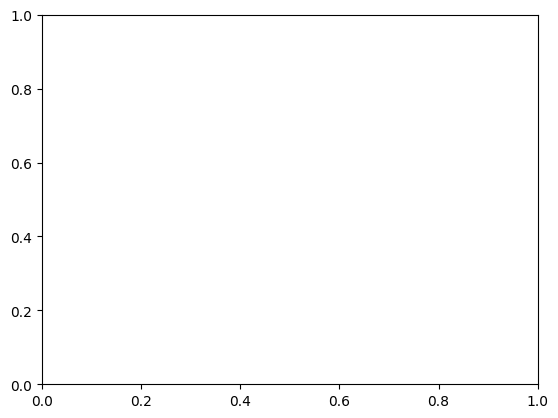

In [ ]:
import matplotlib.pyplot as plt

# Supondo que matrices_x e matrices_y já estejam definidos
# matrices_x.shape = (21676, 12, 2)
# matrices_y.shape = (21676,)

# Criando o tensor matrices_z para armazenar os resultados dos somatórios
matrices_z = np.zeros(matrices_y.shape)

save = False

# Gerando os gráficos, calculando os somatórios, e salvando no Google Drive
for i in range(matrices_x.shape[0]):
    fig, ax = plt.subplots()

    # Eixo X e Y
    x = matrices_x[i, :, 1]
    y = matrices_x[i, :, 0]

    # Cor das barras
    color = 'green' if matrices_y[i] == 1 else 'red'

    # Cálculo de x_mid (ponto médio de X)
    x_mid = (np.max(x) + np.min(x)) / 2

    # Cálculo do somatório
    sum_result = np.sum((x - x_mid) * y)

    # Armazenando o resultado no tensor matrices_z
    matrices_z[i] = sum_result

    # Criando gráfico de barras com barras finas e bordas pretas
    ax.bar(x, y, color=color, edgecolor='black', width=0.001)

    # Adicionando o marcador roxo no ponto médio de X
    ax.axvline(x_mid, color='purple', linestyle=':', label='Mid X')

    # Exibindo o somatório no gráfico
    ax.text(0.5, 0.9, f'{sum_result:.4f}', color=color,
            ha='center', va='center', transform=ax.transAxes, fontsize=10)
    if save:
        # Salvando o gráfico
        plt.savefig(os.path.join(output_dir, f'graph_{i}.png'))

    plt.close(fig)  # Fecha a figura para liberar memória

print(f"Todos os gráficos foram salvos em {output_dir}")

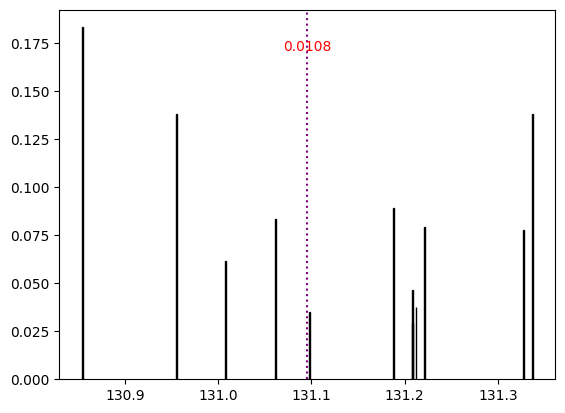

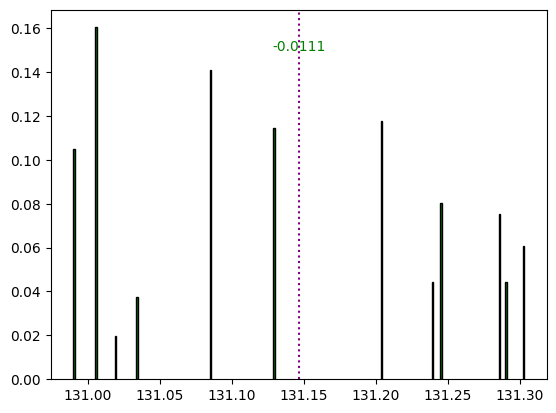

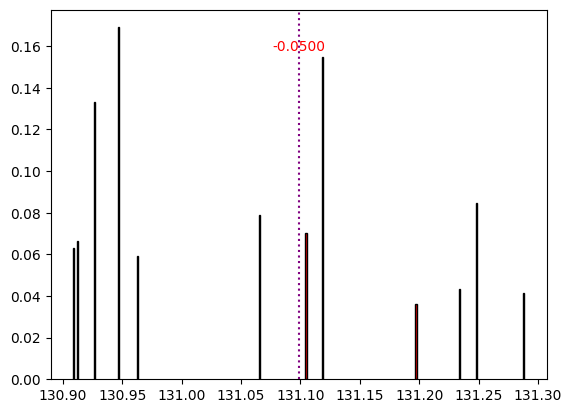

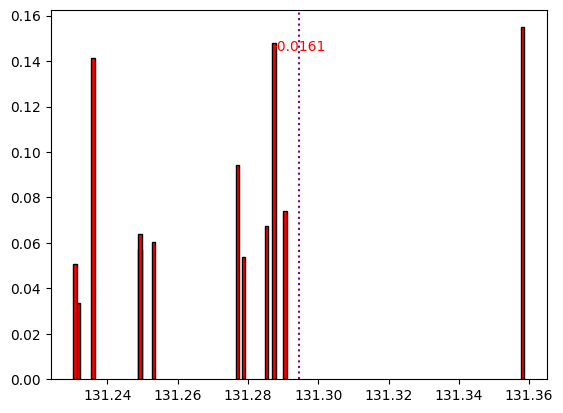

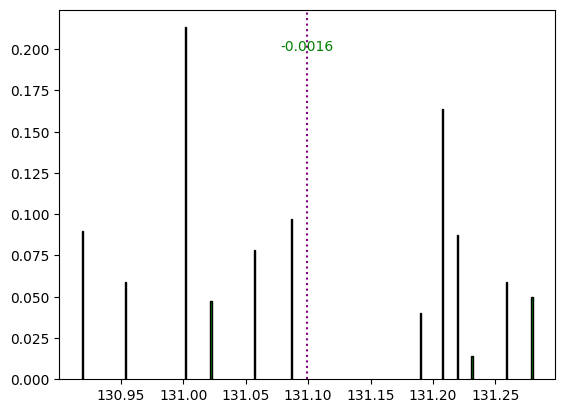

In [ ]:
import matplotlib.pyplot as plt

# Exibir os primeiros 5 gráficos
for i in range(5):
    fig, ax = plt.subplots()

    # Eixo X e Y
    x = matrices_x[i, :, 1]
    y = matrices_x[i, :, 0]

    # Cor das barras
    color = 'green' if matrices_y[i] == 1 else 'red'

    # Cálculo de x_mid (ponto médio de X)
    x_mid = (np.max(x) + np.min(x)) / 2

    # Cálculo do somatório
    sum_result = np.sum((x - x_mid) * y)

    # Armazenando o resultado no tensor matrices_z
    matrices_z[i] = sum_result

    # Criando gráfico de barras com barras finas e bordas pretas
    ax.bar(x, y, color=color, edgecolor='black', width=0.001)

    # Adicionando o marcador roxo no ponto médio de X
    ax.axvline(x_mid, color='purple', linestyle=':', label='Mid X')

    # Exibindo o somatório no gráfico
    ax.text(0.5, 0.9, f'{sum_result:.4f}', color=color,
            ha='center', va='center', transform=ax.transAxes, fontsize=10)

    # Exibir o gráfico
    plt.show()

In [10]:
# Criando o tensor matrices_z para armazenar os resultados dos somatórios
matrices_z = np.zeros(matrices_y.shape)

# Gerando os gráficos, calculando os somatórios, e salvando no Google Drive
for i in range(matrices_x.shape[0]):

    # Eixo X e Y
    x = matrices_x[i, :, 1]
    y = matrices_x[i, :, 0]

    # Cálculo de x_mid (ponto médio de X)
    x_mid = (np.max(x) + np.min(x)) / 2

    # Cálculo do somatório
    sum_result = np.sum((x - x_mid) * y)

    # Armazenando o resultado no tensor matrices_z
    matrices_z[i] = sum_result

print(matrices_z)
print(matrices_z.shape)
print()

[ 0.01078386 -0.01108015 -0.05000791 ... -0.00294459  0.01263257
 -0.00241459]
(15607,)



In [11]:
# Ordenar matrices_z e matrices_y com base em matrices_z
sorted_indices = np.argsort(matrices_z)
sorted_z = matrices_z[sorted_indices]
sorted_y = matrices_y[sorted_indices]

# Inicializar contadores para o cálculo de Correct_X
best_correct_x = None
max_correct_count = -1

# Loop para encontrar o ponto que maximiza os critérios
for i in range(len(sorted_z)):
    left_reds = np.sum(sorted_y[:i] == 0)   # Pontos vermelhos à esquerda
    right_greens = np.sum(sorted_y[i:] == 1) # Pontos verdes à direita

    correct_count = left_reds + right_greens

    # Verifica se esse ponto maximiza os critérios
    if correct_count > max_correct_count:
        max_correct_count = correct_count
        best_correct_x = sorted_z[i]

print(f"O ponto que maximiza os critérios é: {best_correct_x}")

O ponto que maximiza os critérios é: -0.06595908652250884


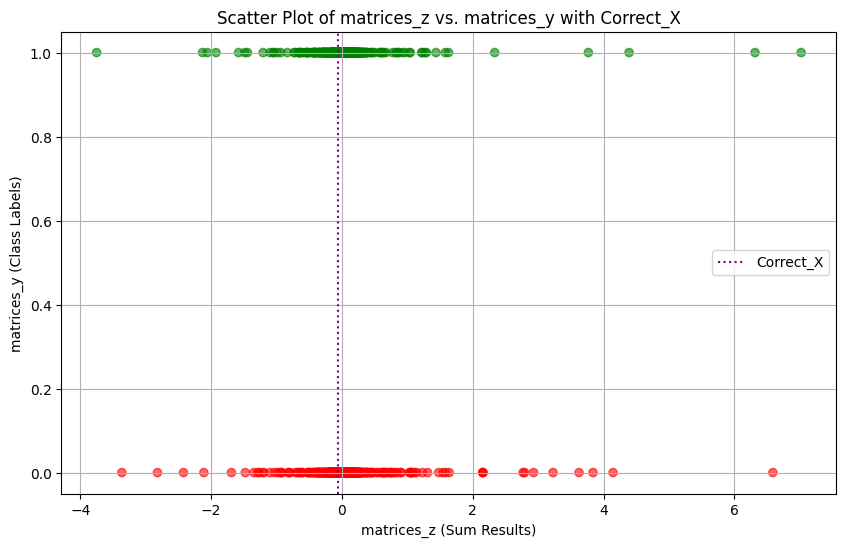

In [12]:
import matplotlib.pyplot as plt

# Criar a lista de cores para os pontos com base nos valores de matrices_y
colors = ['green' if value == 1 else 'red' for value in matrices_y]

# Criar o gráfico de dispersão (scatter plot)
plt.figure(figsize=(10, 6))
plt.scatter(matrices_z, matrices_y, c=colors, alpha=0.6)

# Adicionar a linha roxa vertical em Correct_X
plt.axvline(best_correct_x, color='purple', linestyle=':', label='Correct_X')

# Ajustar a janela de visualização (limites dos eixos)
#plt.xlim([-0.02, 0.02])  # Limites do eixo X
#plt.ylim([-0.1, 1.1])  # Limites do eixo Y para incluir 0 e 1

# Configurações do gráfico
plt.title('Scatter Plot of matrices_z vs. matrices_y with Correct_X')
plt.xlabel('matrices_z (Sum Results)')
plt.ylabel('matrices_y (Class Labels)')
plt.grid(True)
plt.legend()

# Exibir o gráfico
plt.show()

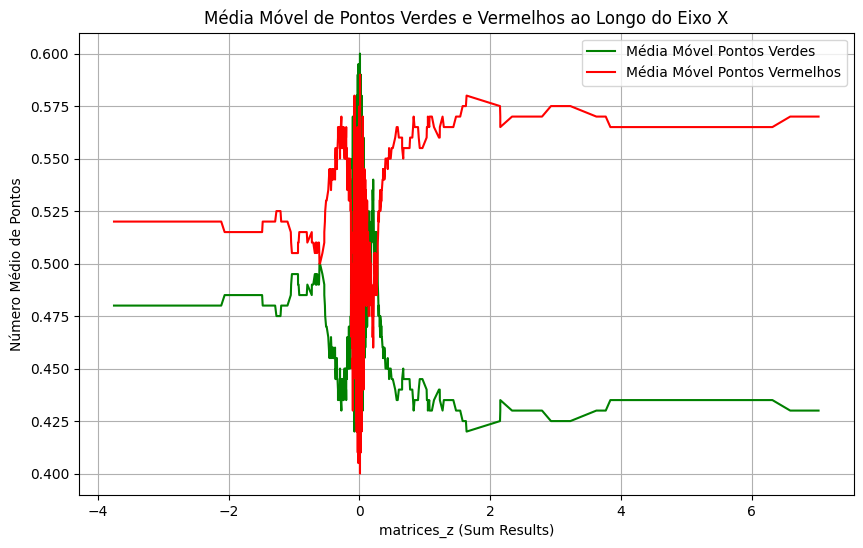

In [13]:
from scipy.ndimage import uniform_filter1d

# Supondo que matrices_z e matrices_y já estejam definidos
# matrices_z.shape = (21676,)
# matrices_y.shape = (21676,)

# Separar os valores de matrices_z em dois grupos: verdes e vermelhos
z_green = matrices_z[matrices_y == 1]
z_red = matrices_z[matrices_y == 0]

# Ordenar os valores de z para garantir uma linha contínua e coerente
z_sorted_indices = np.argsort(matrices_z)
z_sorted = matrices_z[z_sorted_indices]
y_sorted = matrices_y[z_sorted_indices]

# Definir o tamanho da janela de média móvel
window_size = 200  # Ajuste o tamanho conforme necessário

# Calcular a média móvel dos pontos verdes e vermelhos
# Criar máscaras para identificar pontos verdes e vermelhos
mask_green = y_sorted == 1
mask_red = y_sorted == 0

# Média móvel para pontos verdes e vermelhos
mean_green = uniform_filter1d(mask_green.astype(float), size=window_size)
mean_red = uniform_filter1d(mask_red.astype(float), size=window_size)

# Criar o gráfico de médias móveis
plt.figure(figsize=(10, 6))

# Plotar a linha de média móvel para pontos verdes
plt.plot(z_sorted, mean_green, color='green', label='Média Móvel Pontos Verdes')

# Plotar a linha de média móvel para pontos vermelhos
plt.plot(z_sorted, mean_red, color='red', label='Média Móvel Pontos Vermelhos')

# Configurações do gráfico
plt.title('Média Móvel de Pontos Verdes e Vermelhos ao Longo do Eixo X')
plt.xlabel('matrices_z (Sum Results)')
plt.ylabel('Número Médio de Pontos')
plt.grid(True)
plt.legend()

# Exibir o gráfico
plt.show()

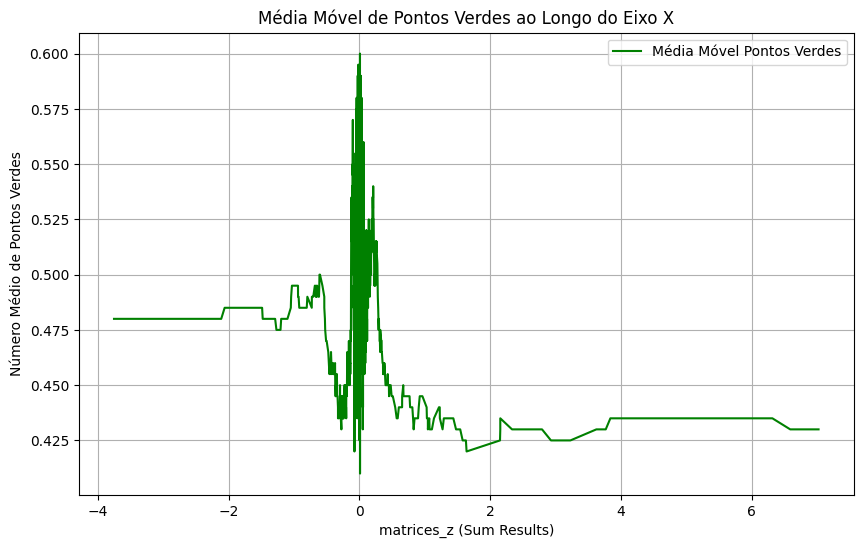

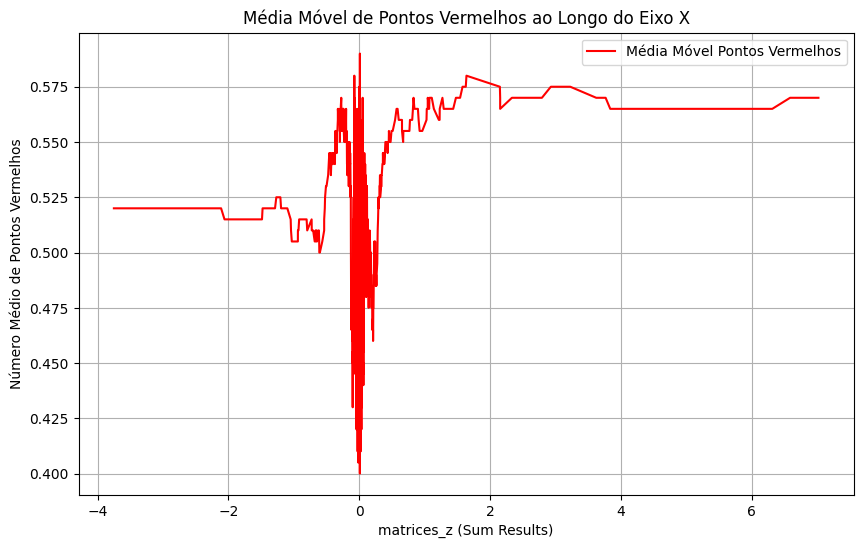

In [14]:
from scipy.ndimage import uniform_filter1d

# Supondo que matrices_z e matrices_y já estejam definidos
# matrices_z.shape = (21676,)
# matrices_y.shape = (21676,)

# Separar os valores de matrices_z em dois grupos: verdes e vermelhos
z_green = matrices_z[matrices_y == 1]
z_red = matrices_z[matrices_y == 0]

# Ordenar os valores de z para garantir uma linha contínua e coerente
z_sorted_indices = np.argsort(matrices_z)
z_sorted = matrices_z[z_sorted_indices]
y_sorted = matrices_y[z_sorted_indices]

# Definir o tamanho da janela de média móvel
window_size = 200  # Ajuste o tamanho conforme necessário

# Calcular a média móvel dos pontos verdes e vermelhos
# Criar máscaras para identificar pontos verdes e vermelhos
mask_green = y_sorted == 1
mask_red = y_sorted == 0

# Média móvel para pontos verdes e vermelhos
mean_green = uniform_filter1d(mask_green.astype(float), size=window_size)
mean_red = uniform_filter1d(mask_red.astype(float), size=window_size)

# Criar o gráfico de média móvel para pontos verdes
plt.figure(figsize=(10, 6))
plt.plot(z_sorted, mean_green, color='green', label='Média Móvel Pontos Verdes')
plt.title('Média Móvel de Pontos Verdes ao Longo do Eixo X')
plt.xlabel('matrices_z (Sum Results)')
plt.ylabel('Número Médio de Pontos Verdes')
plt.grid(True)
plt.legend()
plt.show()

# Criar o gráfico de média móvel para pontos vermelhos
plt.figure(figsize=(10, 6))
plt.plot(z_sorted, mean_red, color='red', label='Média Móvel Pontos Vermelhos')
plt.title('Média Móvel de Pontos Vermelhos ao Longo do Eixo X')
plt.xlabel('matrices_z (Sum Results)')
plt.ylabel('Número Médio de Pontos Vermelhos')
plt.grid(True)
plt.legend()
plt.show()

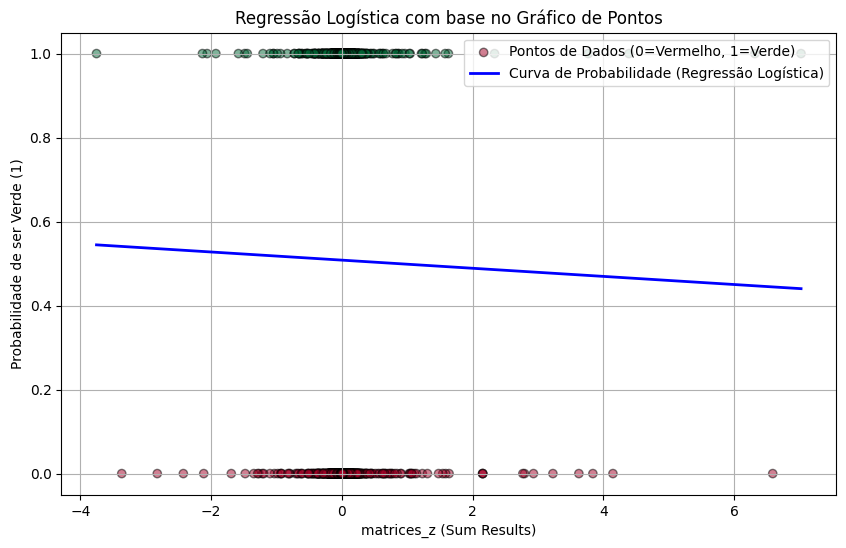

Acurácia do modelo no conjunto de teste: 52.40%


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Supondo que matrices_z e matrices_y já estejam definidos
# matrices_z.shape = (21676,)
# matrices_y.shape = (21676,)

# Preparar os dados para a regressão logística
X = matrices_z.reshape(-1, 1)  # matriz de características (variável independente)
y = matrices_y                 # vetor de rótulos (variável dependente)

# Dividir os dados em conjuntos de treino e teste (opcional, mas recomendado)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e ajustar o modelo de regressão logística
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Fazer previsões de probabilidade para uma gama de valores de X
z_values = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
probabilities = log_reg.predict_proba(z_values)[:, 1]

# Plotar o gráfico de pontos
plt.figure(figsize=(10, 6))
plt.scatter(X, y, c=y, cmap='RdYlGn', alpha=0.5, edgecolors='k', label='Pontos de Dados (0=Vermelho, 1=Verde)')

# Plotar a curva de probabilidade da regressão logística
plt.plot(z_values, probabilities, color='blue', linewidth=2, label='Curva de Probabilidade (Regressão Logística)')

# Adicionar título e rótulos
plt.title('Regressão Logística com base no Gráfico de Pontos')
plt.xlabel('matrices_z (Sum Results)')
plt.ylabel('Probabilidade de ser Verde (1)')
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()

# Avaliar o modelo (opcional)
accuracy = log_reg.score(X_test, y_test)
print(f'Acurácia do modelo no conjunto de teste: {accuracy * 100:.2f}%')

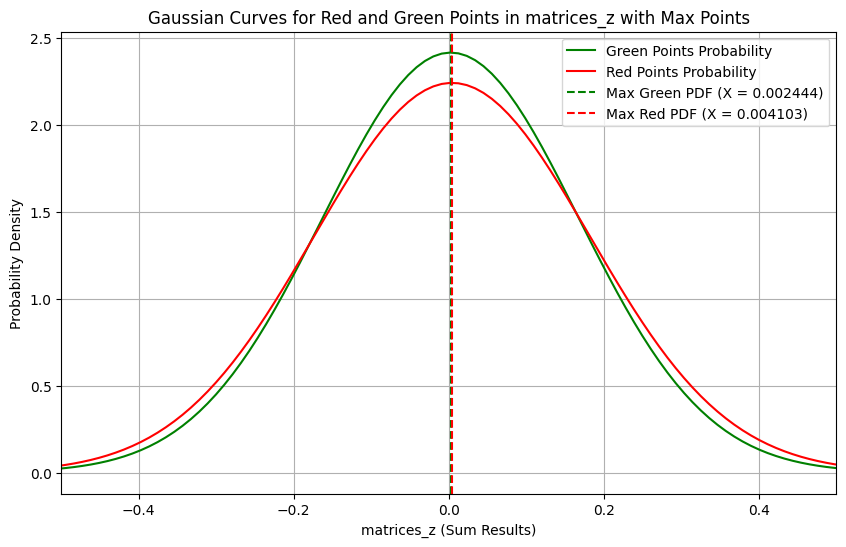

In [15]:
from scipy.stats import norm

# Supondo que matrices_z e matrices_y já estejam definidos
# matrices_z.shape = (21676,)
# matrices_y.shape = (21676,)

# Separar os valores de matrices_z em dois grupos: verdes e vermelhos
z_green = matrices_z[matrices_y == 1]
z_red = matrices_z[matrices_y == 0]

# Calcular os parâmetros das distribuições gaussianas (média e desvio padrão)
mu_green, std_green = np.mean(z_green), np.std(z_green)
mu_red, std_red = np.mean(z_red), np.std(z_red)

# Criar uma linha de valores de z para plotar as gaussianas
z_values = np.linspace(min(matrices_z), max(matrices_z), 1000)

# Calcular as densidades de probabilidade (pdf) para as gaussianas
pdf_green = norm.pdf(z_values, mu_green, std_green)
pdf_red = norm.pdf(z_values, mu_red, std_red)

# Criar o gráfico das duas gaussianas
plt.figure(figsize=(10, 6))

# Plotar a gaussiana verde
plt.plot(z_values, pdf_green, 'g', label='Green Points Probability')

# Plotar a gaussiana vermelha
plt.plot(z_values, pdf_red, 'r', label='Red Points Probability')

# Adicionar linhas verticais nos pontos de máximo das gaussianas com os valores de X na legenda
plt.axvline(mu_green, color='green', linestyle='--', label=f'Max Green PDF (X = {mu_green:.6f})')
plt.axvline(mu_red, color='red', linestyle='--', label=f'Max Red PDF (X = {mu_red:.6f})')

# Ajustar a janela de visualização (limites dos eixos)
plt.xlim([-0.5, 0.5])  # Limites do eixo X
#plt.ylim([-0.1, 1.1])  # Limites do eixo Y para incluir 0 e 1

# Configurações do gráfico
plt.title('Gaussian Curves for Red and Green Points in matrices_z with Max Points')
plt.xlabel('matrices_z (Sum Results)')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()

# Exibir o gráfico
plt.show()

In [16]:
max_pdf_green = 1 / (std_green * np.sqrt(2 * np.pi))
max_pdf_red = 1 / (std_red * np.sqrt(2 * np.pi))

print(f"Máxima densidade de probabilidade para pontos verdes: {max_pdf_green}")
print(f"Máxima densidade de probabilidade para pontos vermelhos: {max_pdf_red}")

Máxima densidade de probabilidade para pontos verdes: 2.416235767083523
Máxima densidade de probabilidade para pontos vermelhos: 2.242032923593705
